# Unzip the file

In [2]:
!gzip -dk data/traffic.pcapng.gz

# Generate traffic flows through pcapML

This step essentially creates a pcap file for each flow in the dataset. All the pcap files are generated under data/traffic_flows/

In [3]:
!pcapml -M data/traffic.pcapng -O data/traffic_flows/

Making output directory
Splitting pcapng


In [4]:
!ls data/traffic_flows/ | head

10000002068136406352_malware_emotet.pcap
10000026091954898561_bengin_benign.pcap
10000037800371447645_malware_ccleaner.pcap
10000113156724180745_malware_artemis.pcap
1000016327458587213_malware_adload.pcap
10000168329093918222_benign_benign.pcap
10000337095817554822_malware_trickbot.pcap
10000358954602436484_malware_tinba.pcap
10000406413035525783_bengin_benign.pcap
10000446970923238640_malware_pua.pcap
ls: write error: Broken pipe


In [5]:
!ls data/traffic_flows/ | wc -l

498447


There are 498447 flows in the dataset.

# Build labels 

This step creates two labeled files (one for easy class, and another for hard). Each file has a row representing the flow: <flow ID,class>.

Below functions normalize the easy and hard labels. Essentially, on close inspection, I found out that the dataset has ambiguous names for benign label. Sometimes the label 'bengin' comes up, and sometimes 'benign7' comes up. I normalize all of them to 'benign'. 

In [ ]:
def normalize_easy_label(lbl: str) -> str:
    lbl = lbl.strip().lower()
    if lbl in ["benign", "bengin", "benign7"]: 
        return "benign"
    elif lbl == "malware":
        return "malware"
    else:
        return lbl 


In [10]:
def normalize_hard_label(lbl: str) -> str:
    lbl = lbl.strip().lower()
    if lbl in ["benign", "benign7", "bengin"]:
        return "benign"
    return lbl


In [11]:
import os
import struct
import pcapml_fe
import re

dataset = "./data/traffic.pcapng"
labels_easy_file = "./data/labels_easy.txt"
labels_hard_file = "./data/labels_hard.txt"

def parse_labels(meta_str):
    s = str(meta_str).strip()
    parts = re.split(r"[,_]", s)
    easy = parts[0]
    hard = parts[1]
    
    return easy, hard


with open(labels_easy_file, "w") as le, open(labels_hard_file, "w") as lh:
    for i, sample in enumerate(pcapml_fe.sampler(dataset)):
        fname = f"{sample.sid}" # Sample ID

        easy, hard = parse_labels(sample.metadata)
        easy = normalize_easy_label(easy)
        hard = normalize_hard_label(hard)

        # Write labels into the file
        le.write(f"{fname},{easy}\n")
        lh.write(f"{fname},{hard}\n")

        # Progress indicator
        if (i + 1) % 100000 == 0:
            print(f"Wrote {i+1} labels...")

print("Easy labels in:", labels_easy_file)
print("Hard labels in:", labels_hard_file)

Wrote 100000 labels...
Wrote 200000 labels...
Wrote 300000 labels...
Wrote 400000 labels...
Easy labels in: ./data/labels_easy.txt
Hard labels in: ./data/labels_hard.txt


# Generate features

This step creates 'nprint' features for each flow. I use the command: ```nprint -P <pcap file> -W <features.csv> -4 -6 -t -u -p 20```. I automate this for all pcap files. This includes IPv4, v6, transport (TCP/UDP) headers, and payload upto 20bytes.

This step will take about ~10-15 minutes.

In [13]:
import subprocess
from pathlib import Path

flows_dir = Path("./data/traffic_flows")
features_dir = Path("./data/flow_features")
features_dir.mkdir(exist_ok=True)

pcaps = sorted(flows_dir.glob("*.pcap"))

def run_nprint(pcap_path):
    base = pcap_path.stem
    out_csv = features_dir / f"{base}.csv"

    if out_csv.exists():
        return out_csv

    cmd = [
        "nprint",
        "-P", str(pcap_path),
        "-W", str(out_csv),
        "-4", "-6", "-t", "-u",
        "-p", "20"
    ]
    subprocess.run(cmd, check=True)
    return out_csv

for i, p in enumerate(pcaps, 1):
    run_nprint(p)

    # Progress indicator
    if i % 100000 == 0:
        print(f"Processed {i} flows...")

print("Features for all flows in:", features_dir)


Processed 100000 flows...
Processed 200000 flows...
Processed 300000 flows...
Processed 400000 flows...
Features for all flows in: data/flow_features


Features for each flow is a separate CSV file under data/flow_features/

# Build a unified dataset for each class

## Generate a map of <sample ID, label>

Now, we generate two maps (for 2 classes). Each map will represent an association of sample ID with the label. 

In [14]:
import pandas as pd

easy_df = pd.read_csv("./data/labels_easy.txt", header=None, names=["sample_id", "easy_label"])
hard_df = pd.read_csv("./data/labels_hard.txt", header=None, names=["sample_id", "hard_label"])

easy_df["sample_id"] = easy_df["sample_id"].astype(str)
hard_df["sample_id"] = hard_df["sample_id"].astype(str)

easy_map = dict(zip(easy_df["sample_id"], easy_df["easy_label"]))
hard_map = dict(zip(hard_df["sample_id"], hard_df["hard_label"]))

print("Easy labels:", len(easy_map))
print("Hard labels:", len(hard_map))


Easy labels: 498446
Hard labels: 498446


## Generate a unified dataset for each class

In [15]:
from pathlib import Path

features_dir = Path("./data/flow_features")
OUT_EASY = Path("./data/all_flow_features_easy.csv")
OUT_HARD = Path("./data/all_flow_features_hard.csv")

csv_files = sorted(features_dir.glob("*.csv"))
print("Num CSV files:", len(csv_files))

if not csv_files:
    raise RuntimeError("No CSV files found in flow_features/")

with csv_files[0].open() as f:
    header = f.readline().strip()

with OUT_EASY.open("w") as out_easy, OUT_HARD.open("w") as out_hard:
    out_easy.write(header + ",sample_id,easy_label\n")
    out_hard.write(header + ",sample_id,hard_label\n")

    # Stream one data line per file
    for i, path in enumerate(csv_files, 1):
        fname = path.name
        sample_id = fname.split("_")[0]

        with path.open() as f:
            _ = f.readline() 
            line = f.readline().strip()

        if not line:
            continue

        # Lookup labels
        sid = str(sample_id)
        easy_label = easy_map.get(sid)
        hard_label = hard_map.get(sid)

        if easy_label is None or hard_label is None:
            continue

        # Write to easy and hard output CSVs
        out_easy.write(f"{line},{sid},{easy_label}\n")
        out_hard.write(f"{line},{sid},{hard_label}\n")

        # Progress indicator
        if i % 50000 == 0:
            print(f"Merged {i} files...")

print("Done.")
print("Unified easy CSV:", OUT_EASY)
print("Unified hard CSV:", OUT_HARD)


Num CSV files: 498446
Merged 50000 files...
Merged 100000 files...
Merged 150000 files...
Merged 200000 files...
Merged 250000 files...
Merged 300000 files...
Merged 350000 files...
Merged 400000 files...
Merged 450000 files...
Done.
Unified easy CSV: data/all_flow_features_easy.csv
Unified hard CSV: data/all_flow_features_hard.csv


Now, we have two unified CSVs (one for each class under data/).

# Dimensionality analysis

Since the dataset is huge (500k flows), its too time-consuming and memory-demanding to run on a conventional machine. Hence, I first perform PCA analysis to understand the no. of components which are actually important for training. 

Note, the PCA also can't be done for the entire dataset at once. Hence, I perform incremental PCA. It involves 3 steps.

## Step-1. Sampling

I first sample 50k flows from the huge dataset. This is performed in chunks to cover the entire dataset. 

In [1]:
import pandas as pd

EASY_CSV = "./data/all_flow_features_easy.csv"
CHUNKSIZE = 20000
TARGET_SAMPLE = 50000

sample_frames = []
total_collected = 0

for chunk in pd.read_csv(EASY_CSV, chunksize=CHUNKSIZE):
    X = chunk.drop(columns=["sample_id", "easy_label"], errors='ignore')
    X = X.select_dtypes(include=["number"])

    if X.shape[0] == 0:
        continue

    need = TARGET_SAMPLE - total_collected
    if need <= 0:
        break

    k = min(len(X), max(1, need // 2))  # grab up to half of remaining target (just a scheme)
    sampled = X.sample(n=k, random_state=42)
    sample_frames.append(sampled)
    total_collected += len(sampled)

    print("So far collected:", total_collected)

easy_sample = pd.concat(sample_frames, ignore_index=True)
print("Collected total:", len(easy_sample))

# Remove overshooting
if len(easy_sample) > TARGET_SAMPLE:
    easy_sample = easy_sample.sample(TARGET_SAMPLE, random_state=42)

print("Final sample shape:", easy_sample.shape)


So far collected: 20000
So far collected: 35000
So far collected: 42500
So far collected: 46250
So far collected: 48125
So far collected: 49062
So far collected: 49531
So far collected: 49765
So far collected: 49882
So far collected: 49941
So far collected: 49970
So far collected: 49985
So far collected: 49992
So far collected: 49996
So far collected: 49998
So far collected: 49999
So far collected: 50000
Collected total: 50000
Final sample shape: (50000, 1504)


## Step-2: Explained variance

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
easy_scaled = scaler.fit_transform(easy_sample)

MAX_COMPONENTS = 200

pca = PCA(n_components=MAX_COMPONENTS)
pca.fit(easy_scaled)

explained = pca.explained_variance_ratio_
cum = explained.cumsum()

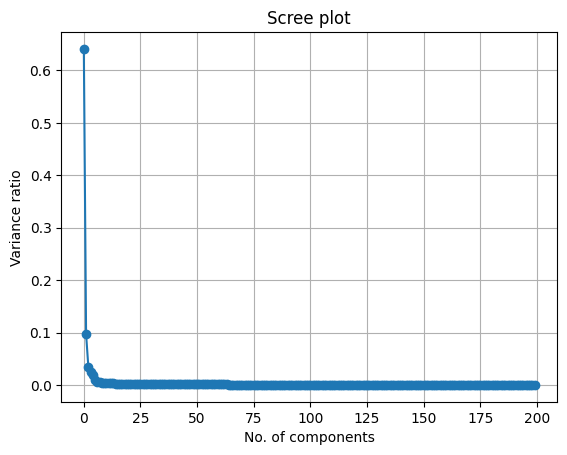

In [3]:
plt.plot(explained, marker="o")
plt.title("Scree plot")
plt.xlabel("No. of components")
plt.ylabel("Variance ratio")
plt.grid(True)
plt.show()

Hence, I take 15 features.

## Step-3: Prepare new datasets with reduced feature dimensions

The below code was generated using LLM. The point is to perform incremental PCA over streaming dataset chunks.

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import numpy as np

EASY_CSV = "./data/all_flow_features_easy.csv"
OUT_EASY_PCA = "./data/easy_pca_15_components.csv"
N_COMPONENTS = 15
CHUNKSIZE = 20000

scaler_easy = StandardScaler()
pca_easy = IncrementalPCA(n_components=N_COMPONENTS)

for chunk in pd.read_csv(EASY_CSV, chunksize=CHUNKSIZE):
    X = chunk.drop(columns=["sample_id", "easy_label"])
    X = X.select_dtypes(include=[np.number])
    scaler_easy.partial_fit(X)

for chunk in pd.read_csv(EASY_CSV, chunksize=CHUNKSIZE):
    X = chunk.drop(columns=["sample_id", "easy_label"])
    X = X.select_dtypes(include=[np.number])
    X_scaled = scaler_easy.transform(X)
    pca_easy.partial_fit(X_scaled)

first_write = True
for chunk in pd.read_csv(EASY_CSV, chunksize=CHUNKSIZE):
    sample_ids = chunk["sample_id"].reset_index(drop=True)
    labels = chunk["easy_label"].reset_index(drop=True)

    X = chunk.drop(columns=["sample_id", "easy_label"])
    X = X.select_dtypes(include=[np.number])
    X_scaled = scaler_easy.transform(X)
    X_pca = pca_easy.transform(X_scaled)

    df_out = pd.DataFrame(X_pca, columns=[f"pc{i}" for i in range(N_COMPONENTS)])
    df_out["sample_id"] = sample_ids
    df_out["easy_label"] = labels

    df_out.to_csv(
        OUT_EASY_PCA,
        index=False,
        mode="w" if first_write else "a",
        header=first_write,
    )
    first_write = False

print("Reduced easy PCA dataset written to", OUT_EASY_PCA)

Reduced easy PCA dataset written to ./data/easy_pca_15_components.csv


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

HARD_CSV = "./data/all_flow_features_hard.csv"
OUT_HARD_PCA = "./data/hard_pca_15_components.csv"
N_COMPONENTS = 15
CHUNKSIZE = 20000

scaler_hard = StandardScaler()
pca_hard = IncrementalPCA(n_components=N_COMPONENTS)

for chunk in pd.read_csv(HARD_CSV, chunksize=CHUNKSIZE):
    X = chunk.drop(columns=["sample_id", "hard_label"])
    X = X.select_dtypes(include=[np.number])
    scaler_hard.partial_fit(X)

for chunk in pd.read_csv(HARD_CSV, chunksize=CHUNKSIZE):
    X = chunk.drop(columns=["sample_id", "hard_label"])
    X = X.select_dtypes(include=[np.number])
    X_scaled = scaler_hard.transform(X)
    pca_hard.partial_fit(X_scaled)

first_write = True
for chunk in pd.read_csv(HARD_CSV, chunksize=CHUNKSIZE):
    sample_ids = chunk["sample_id"].reset_index(drop=True)
    labels = chunk["hard_label"].reset_index(drop=True)

    X = chunk.drop(columns=["sample_id", "hard_label"])
    X = X.select_dtypes(include=[np.number])
    X_scaled = scaler_hard.transform(X)
    X_pca = pca_hard.transform(X_scaled)

    df_out = pd.DataFrame(X_pca, columns=[f"pc{i}" for i in range(N_COMPONENTS)])
    df_out["sample_id"] = sample_ids
    df_out["hard_label"] = labels

    df_out.to_csv(
        OUT_HARD_PCA,
        index=False,
        mode="w" if first_write else "a",
        header=first_write,
    )
    first_write = False

print("Reduced hard PCA dataset written to", OUT_HARD_PCA)

Reduced hard PCA dataset written to ./data/hard_pca_15_components.csv


Two new files are generated (reduced dimensionality). These files will be used for training. **Easy** dataset is generated under ```data/easy_pca_15_components.csv```. **Hard** dataset is under ```data/hard_pca_15_components.csv```.

# Preparation for training

## Data X and labels y

In [10]:
import pandas as pd

easy_pca = pd.read_csv("./data/easy_pca_15_components.csv")
hard_pca = pd.read_csv("./data/hard_pca_15_components.csv")

X_easy = easy_pca[[c for c in easy_pca.columns if c.startswith("pc")]]
y_easy = easy_pca["easy_label"]

X_hard = hard_pca[[c for c in hard_pca.columns if c.startswith("pc")]]
y_hard = hard_pca["hard_label"]

print("Easy:", X_easy.shape, "labels:", y_easy.unique())
print("Hard:", X_hard.shape, "labels:", len(y_hard.unique()), "classes")


Easy: (498446, 15) labels: ['malware' 'benign']
Hard: (498446, 15) labels: 19 classes


## Models

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import numpy as np

def get_models():
    models = {}

    models["RandomForest"] = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    models["LogReg"] = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000)
    )

    models["SGD_logreg"] = make_pipeline(
        StandardScaler(),
        SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3)
    )

    return models


## Training and test split

In [12]:
from sklearn.model_selection import train_test_split

X_train_easy, X_val_easy, y_train_easy, y_val_easy = train_test_split(
    X_easy, y_easy, test_size=0.2, stratify=y_easy, random_state=42
)

X_train_hard, X_val_hard, y_train_hard, y_val_hard = train_test_split(
    X_hard, y_hard, test_size=0.2, stratify=y_hard, random_state=42
)


# Evaluation

In [13]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_models_once(X_train, y_train, X_val, y_val, task="easy"):
    models = get_models()
    results = []

    for name, model in models.items():
        print(f"\n=== {task.upper()} — Training {name} ===")
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        bacc = balanced_accuracy_score(y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average="macro", zero_division=0
        )

        results.append({
            "task": task,
            "model": name,
            "acc": acc,
            "balanced_acc": bacc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1
        })

        print(f"acc={acc:.4f}, bacc={bacc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{task.upper()} – Confusion Matrix ({name})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)



=== EASY — Training RandomForest ===
acc=1.0000, bacc=0.9999, prec=1.0000, rec=0.9999, f1=1.0000


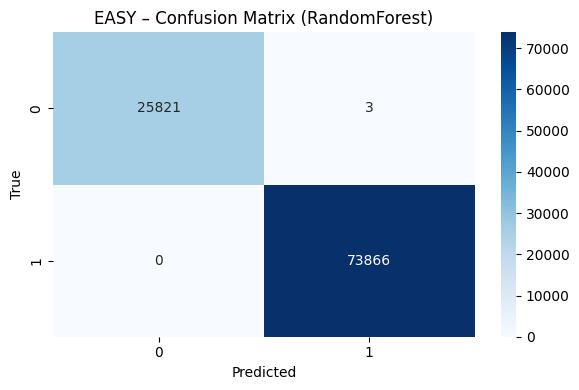


=== EASY — Training LogReg ===
acc=0.9999, bacc=0.9999, prec=0.9999, rec=0.9999, f1=0.9999


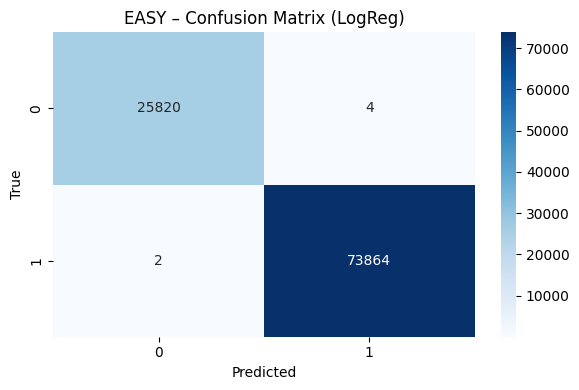


=== EASY — Training SGD_logreg ===
acc=0.9999, bacc=0.9999, prec=0.9999, rec=0.9999, f1=0.9999


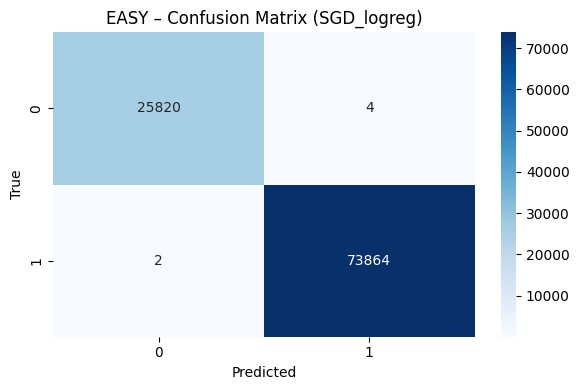


=== HARD — Training RandomForest ===
acc=0.8845, bacc=0.7035, prec=0.7075, rec=0.7035, f1=0.7052


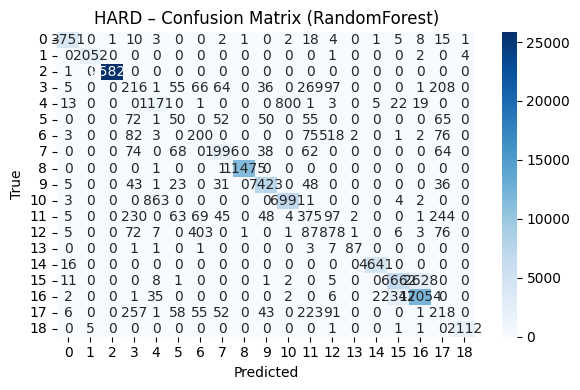


=== HARD — Training LogReg ===
acc=0.8322, bacc=0.5839, prec=0.6699, rec=0.5839, f1=0.5946


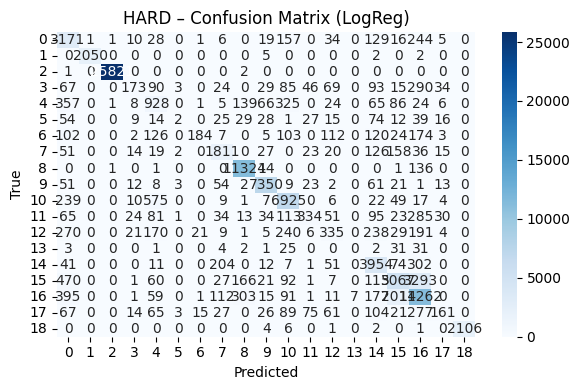


=== HARD — Training SGD_logreg ===
acc=0.8002, bacc=0.5284, prec=0.6305, rec=0.5284, f1=0.5380


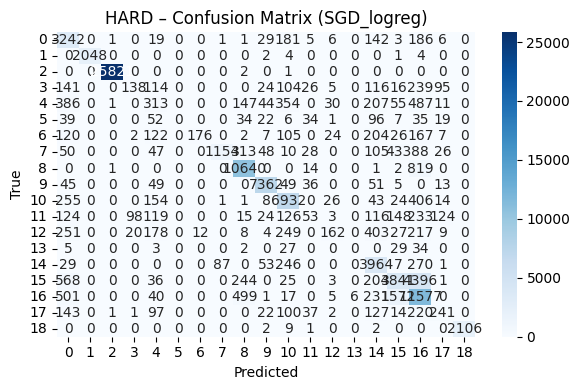

Easy results:
   task         model      acc  balanced_acc  precision_macro  recall_macro  \
0  easy  RandomForest  0.99997      0.999942         0.999980      0.999942   
1  easy        LogReg  0.99994      0.999909         0.999934      0.999909   
2  easy    SGD_logreg  0.99994      0.999909         0.999934      0.999909   

   f1_macro  
0  0.999961  
1  0.999922  
2  0.999922  

Hard results:
   task         model       acc  balanced_acc  precision_macro  recall_macro  \
0  hard  RandomForest  0.884492      0.703461         0.707550      0.703461   
1  hard        LogReg  0.832160      0.583881         0.669906      0.583881   
2  hard    SGD_logreg  0.800181      0.528432         0.630543      0.528432   

   f1_macro  
0  0.705189  
1  0.594641  
2  0.538007  


In [14]:
results_easy = evaluate_models_once(
    X_train_easy, y_train_easy, X_val_easy, y_val_easy, task="easy"
)

results_hard = evaluate_models_once(
    X_train_hard, y_train_hard, X_val_hard, y_val_hard, task="hard"
)

print("Easy results:")
print(results_easy)

print("\nHard results:")
print(results_hard)

Hence, we see that **easy** results are >99% for balanced accuracy across all models. However, they don't perform good enough for **hard** class. Hence, now I test other models as well. 

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np

def get_models_v2(n_classes_hard=None):
    models = {}

    models["ExtraTrees"] = ExtraTreesClassifier(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample"
    )

    models["HistGB"] = HistGradientBoostingClassifier(
        max_depth=None,
        learning_rate=0.1,
        max_iter=300,
        random_state=42
    )

    models["GradBoost"] = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        random_state=42
    )

    models["SGD_logreg"] = make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss="log_loss",
            max_iter=2000,
            tol=1e-3,
            class_weight="balanced"
        )
    )

    models["SVM_rbf"] = make_pipeline(
        StandardScaler(),
        SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            class_weight="balanced",
            probability=False
        )
    )

    if n_classes_hard is not None:
        models["XGB_multi"] = XGBClassifier(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softprob",
            num_class=n_classes_hard,
            tree_method="hist",
            eval_metric="mlogloss",
            n_jobs=-1,
            random_state=42
        )

    return models


In [17]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_models_once_v2(X_train, y_train, X_val, y_val, task="hard"):
    models = get_models_v2()
    results = []

    for name, model in models.items():
        print(f"\n=== {task.upper()} — Training {name} ===")
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        bacc = balanced_accuracy_score(y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average="macro", zero_division=0
        )

        results.append({
            "task": task,
            "model": name,
            "acc": acc,
            "balanced_acc": bacc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1
        })

        print(f"acc={acc:.4f}, bacc={bacc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{task.upper()} – Confusion Matrix ({name})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)



=== HARD — Training ExtraTrees ===
acc=0.8813, bacc=0.6937, prec=0.7192, rec=0.6937, f1=0.6974


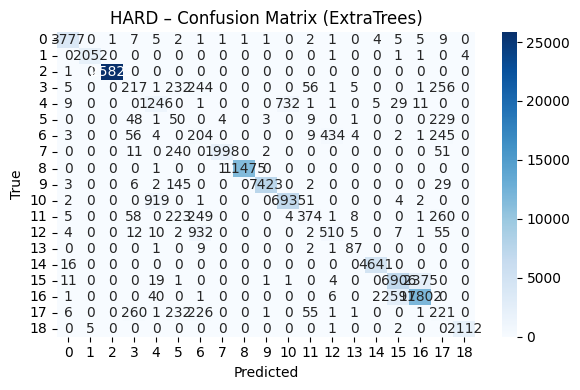


=== HARD — Training HistGB ===
acc=0.9010, bacc=0.7329, prec=0.7081, rec=0.7329, f1=0.7070


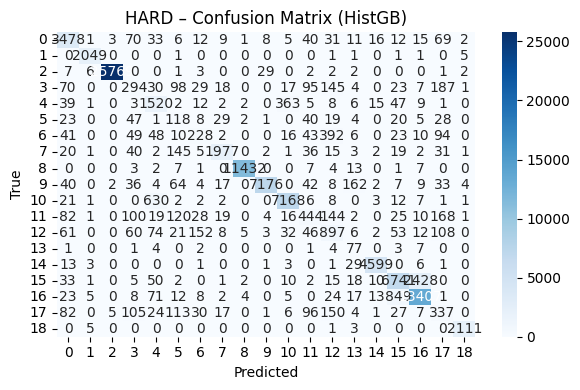


=== HARD — Training GradBoost ===


KeyboardInterrupt: 

In [18]:
results_hard = evaluate_models_once(
    X_train_hard, y_train_hard, X_val_hard, y_val_hard, task="hard"
)
print("\nHard results:")
print(results_hard)

# netML reproduction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

train_data_ag = X_train_easy.copy()
train_data_ag["label"] = y_train_easy

from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(
    label="label",
    problem_type="multiclass",
    verbosity=0,
)

_ = predictor.fit(
    train_data=train_data_ag,
    time_limit=300,
    presets="medium_quality_faster_train",
    verbosity=0,
)

y_pred = predictor.predict(X_val_easy)

print("Autogluon accuracy:         ",
      accuracy_score(y_val_easy, y_pred))
print("Autogluon balanced accuracy:",
      balanced_accuracy_score(y_val_easy, y_pred))